# Introduction
# Getting Ready for This Homework
# Programming Tasks
## Building and Training Your GAN

In [127]:
import torch
from torch import nn

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = out + identity
        return self.relu(out)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # input image 3x64x64
        # Add downsampling layers
        model = [
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        ] #64x32x32
        model += [
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        ]
        
        self.model1 = nn.Sequential(*model)
        
        self.resblock = nn.Sequential(ResBlock(128, 128), ResBlock(128, 128))
        
        model2 = [
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        ] #64x32x32
        model2 += [
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        ]
        
#         n_downsampling = 3
#         for i in range(n_downsampling):
#             mult = 2**i
#             model += [nn.Conv2d(64*mult, 64*mult*2, kernel_size=4, stride=2, padding=1),
#                       nn.BatchNorm2d(64*mult*2),
#                       nn.ReLU(True)]
            
#         # 512x4x4
        model2 += [
            nn.Conv2d(512, 1, kernel_size=4, padding=0),
        ]
        
#         # 1x1x1
        self.model2 = nn.Sequential(*model2)
        
    def forward(self, x):
        x = self.model1(x)
        x = self.resblock(x)
        x = self.model2(x)
        return x
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # in 100x1x1
        model = [
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        ] # 512x4x4
        model += [
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        ]
        model += [
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        ]
        model += [
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        ]
        # n_upsampling = 3
        # for i in reversed(range(n_upsampling)):
        #     mult = 2**i
        #     model += [
        #         nn.ConvTranspose2d(64*mult*2, 64*mult, kernel_size=4, stride=2, padding=1, bias=False),
        #         nn.BatchNorm2d(64*mult),
        #         nn.ReLU(True)
        #     ]
        # 64x32x32
        model += [
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(3),
            nn.Sigmoid()
            # nn.Tanh()
        ]
        # 3x64x64
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)
        


In [128]:
model = Discriminator()
disc_params = sum(p.numel() for p in model.parameters())
print(model(torch.randn(1, 3, 64, 64)).shape)

model = Generator()
gen_params = sum(p.numel() for p in model.parameters())

print("disc", disc_params)
print("gen ", gen_params)

torch.Size([1, 1, 1, 1])
disc 3357889
gen  3577216


In [3]:
import os
from PIL import Image
import torchvision.transforms as tvt

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        super().__init__()
        self.root_dir = root_dir
        self.filelist = os.listdir(root_dir)
        self.transform = tvt.ToTensor()

                
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, index):
        filename = self.filelist[index] 
        pic = Image.open(os.path.join(self.root_dir,filename)).convert("RGB")
        img = self.transform(pic)
        
        return img

In [4]:
trainDataset = MyDataset("dataset/train")
trainDataloader = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=32, num_workers=4)

In [129]:
import numpy as np

def train_dc(generator, discriminator, dataloader):
    generator.train()
    discriminator.train()
    
    losses = list()
    device = torch.device('cuda')
    disc = descriminator.to(device)
    gen = generator.to(device)
    
    criterion = torch.nn.BCELoss()
        
    discOpt = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=(0.5, 0.99))
    genOpt = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.99))
    # discOpt = torch.optim.SGD(disc.parameters(), lr=1e-3)
    # genOpt = torch.optim.SGD(gen.parameters(), lr=1e-3)
    
    real_label = 1
    fake_label = 0
    
    discLossRun = 0
    genLossRun = 0
    
    sigmoid = nn.Sigmoid().to(device)
    
    epochs = 5
    numiters = 0
    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            # print("loaded")
            realImgs = data
            realImgs = realImgs.to(device)
            
            discOpt.zero_grad()
            b_size = realImgs.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            predLabel = sigmoid(disc(realImgs).view(-1))
            realLoss = criterion(predLabel, label)
            realLoss.backward() # call backward separately since internal input data saved in model needed for gradient calc is destoryed when called again
            
            noise = torch.randn(b_size, 100, 1, 1, device=device)
            fakes = gen(noise)
            label.fill_(fake_label)
            predLabel = sigmoid(disc(fakes.detach()).view(-1))
            fakeLoss = criterion(predLabel, label)
            fakeLoss.backward()
            
            discOpt.step()
            discLossRun += realLoss.item() + fakeLoss.item()
            
            
            genOpt.zero_grad()
            label.fill_(real_label)
            predLabel = sigmoid(disc(fakes).view(-1))
            genLoss = criterion(predLabel, label)
            genLoss.backward()
            genOpt.step()
            genLossRun += genLoss.item()
            
            
            if (numiters + 1) % 100 == 0:
                losses.append([discLossRun/100, genLossRun/100])
                discLossRun = 0
                genLossRun = 0
            numiters += 1
        print(f"completed epoch {epoch}: Losses: {losses[-1]}")

    return np.array(losses).T

In [130]:
generator = Generator()
descriminator = Discriminator()
losses = train_dc(generator, descriminator, trainDataloader)

completed epoch 0: Losses: [0.37170124475603006, 7.452169058322906]
completed epoch 1: Losses: [0.613098782238958, 4.9381995308399205]
completed epoch 2: Losses: [0.6920804906962439, 4.50283677637577]
completed epoch 3: Losses: [0.6439648367580958, 4.066453339457512]
completed epoch 4: Losses: [0.5866125845344504, 4.357323987483978]


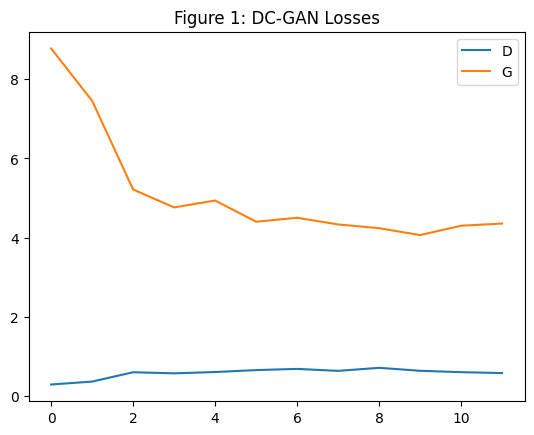

In [131]:
import matplotlib.pyplot as plt

plt.plot(losses.T)
plt.legend(["D", "G"])
plt.title("Figure 1: DC-GAN Losses")
plt.show()

In [109]:
def train_w(generator, critic, dataloader):
    generator.train()
    critic.train()
    
    losses = list()
    device = torch.device('cuda')
    critic = critic.to(device)
    gen = generator.to(device)
        
    critOpt = torch.optim.Adam(critic.parameters(), lr=2e-4, betas=(0.5, 0.99))
    genOpt = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5,0.99))
    
    real_dir = torch.tensor(-1, dtype=torch.float).to(device)
    fake_dir = torch.tensor(1, dtype=torch.float).to(device)
    
    criticLossRun = 0
    genLossRun = 0
    
    relu = nn.ReLU(True)
        
    epochs = 5
    ncritic = 5
    numiters = 0
    for epoch in range(epochs):
        i = 0
        data_iter = iter(dataloader)

        while i < len(dataloader):
            i += 1
            critOpt.zero_grad()
            data = next(data_iter)
            realImgs = data.to(device)
            
            for p in critic.parameters():
                p.data.clamp_(-0.01, 0.01)

            critEstReal = critic(realImgs).view(-1).mean()
            critEstReal.backward(real_dir)

            b_size = realImgs.size(0)
            noise = torch.randn(b_size, 100, 1, 1, device=device)
            fakes = gen(noise)
            critEstFake = critic(fakes.detach()).view(-1).mean()
            critEstFake.backward(fake_dir)

            wasser_dist = critEstReal.item() - critEstFake.item()
            crit_loss = critEstFake.item() - critEstReal.item()
            critOpt.step()

            # gen
            genOpt.zero_grad()
            noise = torch.randn(b_size, 100, 1, 1, device=device)
            fakes = gen(noise)
            critEst = critic(fakes).view(-1).mean()
            critEst.backward(real_dir)

            criticLossRun += crit_loss
            genLossRun += critEst.item()
            genOpt.step()

            if (numiters + 1) % 100 == 0:
                losses.append([criticLossRun/100, genLossRun/100])
                criticLossRun = 0
                genLossRun = 0
            numiters += 1
        print(f"completed epoch {epoch}: Losses: {losses[-1]}")

    return np.array(losses).T

In [110]:
wgenerator = Generator()
wcritic = Discriminator()
wlosses = train_w(wgenerator, wcritic, trainDataloader)

completed epoch 0: Losses: [-0.042490944266319275, 0.5455681458115578]
completed epoch 1: Losses: [-0.7197881307452917, -0.5512438476085663]
completed epoch 2: Losses: [-0.7287727976217866, -0.538675782084465]
completed epoch 3: Losses: [-0.6580341376364232, -0.280303668603301]
completed epoch 4: Losses: [-0.8207318384200335, -0.5497456833720207]


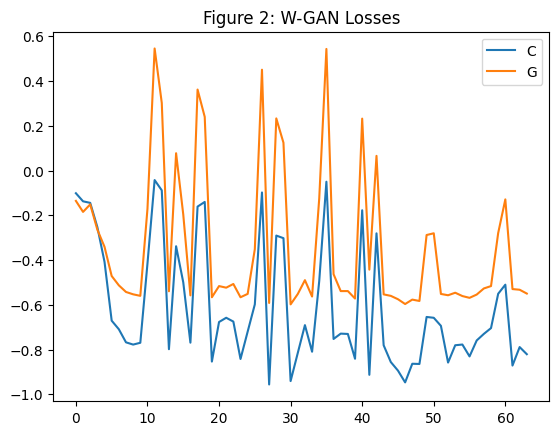

In [111]:
plt.plot(wlosses.T)
plt.legend(["C", "G"])
plt.title("Figure 2: W-GAN Losses")
plt.show()

## Evaluating Your GAN

In [134]:
def generate_samples(directory, generator):
    generator.eval()
    device = torch.device('cuda')
    gen = generator.to(device)
    toPil = tvt.ToPILImage()

    with torch.no_grad():
        for i in range(1000):
            noise = torch.randn(1, 100, 1, 1, device=device)
            img = gen(noise)
            pic = toPil(img[0])
            filename = '{:05}.jpg'.format(i)
            pic.save(os.path.join(directory, filename))

In [135]:
generate_samples("dataset/dc_samps", generator)

In [136]:
generate_samples("dataset/w_samps", wgenerator)

In [137]:
from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
from pytorch_fid.inception import InceptionV3

def calculate_fid(directory):
    device = torch.device('cuda')
    
    real_imgs = os.listdir("dataset/eval")
    real_paths = [os.path.join("dataset/eval", filename) for filename in real_imgs]
    fake_imgs = os.listdir(directory)
    fake_paths = [os.path.join(directory, filename) for filename in fake_imgs]
    
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    m1, s1 = calculate_activation_statistics(real_paths, model, device=device)
    m2, s2 = calculate_activation_statistics(fake_paths, model, device=device)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
    return fid_value

In [138]:
dc_fid = calculate_fid("dataset/dc_samps")
w_fid = calculate_fid("dataset/w_samps")

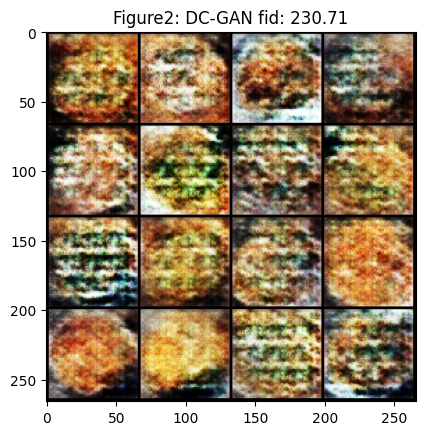

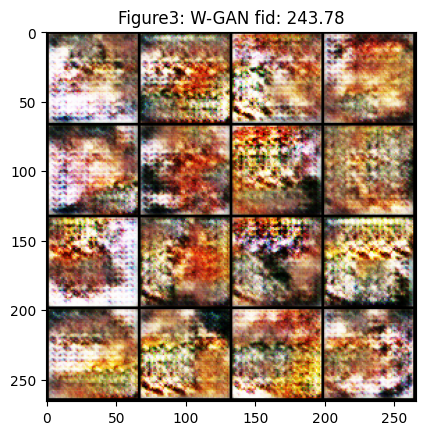

In [139]:
import torchvision

def show_results(name, num, generator, fid):
    device = torch.device('cuda')
    generator = generator.to(device)
    noise = torch.randn(16, 100, 1, 1).to(device)
    imgs = generator(noise)
    grid_img = torchvision.utils.make_grid(imgs, 4)
    plt.figure()
    toPic = tvt.ToPILImage()
    plt.imshow(toPic(grid_img.cpu()))
    plt.title(f"Figure{num}: {name} fid: {fid:.2f}")
    plt.show()

show_results("DC-GAN", 2, generator, dc_fid)
show_results("W-GAN", 3, wgenerator, w_fid)

Well both of my results are pretty bad. My DC-GAN was ok on my first try somehow, but have since lost the results. Seems like I'm having model collapse in both cases but can't seem to figure out how to solve it. I've tried making the model parameters near same and adjusting the learning rate/ momentum first order term, but can't get it to do anything. 